In [1]:
import pandas as pd
import requests
import json
import numpy as np


In [2]:
headers = {"Authorization": "Api-Key pnOscX2f.Q48hIMJw3MFjDvJbqXza1WPdIcww0AHm"}
res = requests.get('http://157.230.202.235:8001/api/obs/events/', headers=headers)
data = res.json()
print(data)

{'success': True, 'events': [{'id': 1047797, 'source_link': 'https://www.foxnews.com/media/cnn-adeel-raja-says-world-today-needs-a-hitler', 'classified_category': None, 'tags_list': '[]', 'address': None, 'geolocation': None, 'has_media': False, 'media_link': None, 'updated_at': '2021-05-16T21:54:49.461338Z', 'meta_json': '{"url": "https://www.foxnews.com/media/cnn-adeel-raja-says-world-today-needs-a-hitler", "authors": ["Cortney O\'Brien", "Cortney O\'Brien Is Editor", "Flash At Fox News. Follow Her On Twitter At"], "publish_date": "None", "text": "Social media users are demanding CNN respond after discovering that one of their freelance contributors, Adeel Raja, who has written dozens of pieces for the outlet, wrote in a now-deleted tweet that \\"the world today needs a Hitler.\\" After some digging, it turned out to be one of several messages Raja has posted praising the Nazi leader.\\n\\n\\"The only reason I am supporting Germany in the finals - Hitler was a German and he did good 

In [3]:
texts =[]

for txt in data['events']:
  try:
    temp =json.loads(txt['meta_json'])
    texts.append(temp['text'])
  except:
    pass

In [4]:
df = pd.DataFrame(texts,columns=['text'])
df.head()

,text
0,Social media users are demanding CNN respond a...
1,Israeli Prime Minister Benjamin Netanyahu dire...
2,The Brooklyn Nets enter Sunday night’s game ag...
3,
4,


In [5]:
df['text'][2]

'The Brooklyn Nets enter Sunday night’s game against the Cleveland Cavaliers with a chance to lock up the No. 2 seed in the Eastern Conference, and with the trio of Kevin Durant, James Harden and Kyrie Irving leading the way, they have obvious championship aspirations heading into the postseason.\n\nAfter the Nets rolled to a 105-91 victory over the Chicago Bulls on Saturday night, Irving, who was fined last week for repeated failure to meet with the media, took an interesting approach with reporters this time around by saying basketball isn’t his main focus right now because of everything going on in the world, including the Israel-Palestinian conflict.\n\nCLICK HERE FOR MORE SPORTS COVERAGE ON FOXNEWS.COM\n\n"I’m not going to lie to you guys, a lot of stuff is going on in this world, and basketball is just not the most important thing to me right now," Irving said, via ESPN . "There’s a lot of things going on overseas. All our people are still in bondage across the world, and there’s

In [6]:
len(df[df['text'] == ''])

123

In [7]:
df.loc[df['text'] == "", 'text'] = np.nan
df1 =df.dropna(subset=['text'],axis=0)
df1 = df1.reset_index()

In [8]:
df1.head()

,index,text
0,0,Social media users are demanding CNN respond a...
1,1,Israeli Prime Minister Benjamin Netanyahu dire...
2,2,The Brooklyn Nets enter Sunday night’s game ag...
3,5,Nebraska Governor Pete Ricketts said he found ...
4,11,"Villagers grow flowers in Shanchong Village, Z..."


In [9]:
len(df1)

196

<h2><b> Processing pipeline </b></h2>

In [10]:
import string
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS


In [11]:
stopwords = list(STOP_WORDS)
punct = string.punctuation

In [12]:
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
def stopwords_lemma(sentence):
    doc = nlp.make_doc(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().replace('\n','').strip()
        else:
            temp = token.lower_.replace('\n','')
        tokens.append(temp)
      
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
    return cleaned_tokens

In [14]:
df1['processed'] = [stopwords_lemma(i) for i in df1['text']]

<h2><b>Model Training </b></h2>

In [15]:
!pip install sentence-transformers


     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 2.3MB 8.6MB/s 
     |████████████████████████████████| 1.2MB 31.9MB/s 
     |████████████████████████████████| 3.3MB 42.4MB/s 
     |████████████████████████████████| 901kB 36.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.1-cp37-none-any.whl size=123338 sha256=2291878893c290795db9cd13988d73cc50c68bd56c8c8a1915a80b12a5aeb68b
  Stored in directory: /root/.cache/pip/wheels/5e/89/29/45e45adc162b50f97f71801e8b07947c9cfe2b3ae7dbf37896
Successfully built sentence-transformers


In [16]:
from sentence_transformers import SentenceTransformer

sentence_bert_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

def get_embeddings(sentences):
    return sentence_bert_model.encode(sentences,
                                    batch_size=32, 
                                    show_progress_bar=True)

In [17]:
bert_embedding = get_embeddings(df1['processed'])


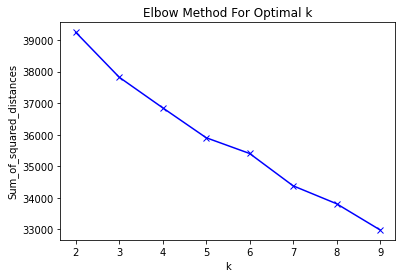

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(bert_embedding)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [19]:
n_clusters = 7
clf= KMeans(n_clusters=n_clusters,init='k-means++', n_init=10, max_iter=1000, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='auto')
prediction = clf.fit_predict(bert_embedding)
labels = clf.labels_


In [20]:
article_cl=pd.DataFrame(list(zip(df['text'],prediction)),columns=['title','cluster'])
print(article_cl.sort_values(by=['cluster']))

                                                 title  cluster
43                                                 NaN        0
28   Escucha esta nota aquí\n\nLa actriz Daisy Ridl...        0
29                                                 NaN        0
150  #Mucormycosis, commonly known as '#BlackFungus...        0
144  India reports 3,11,170 new #COVID19 cases, 3,6...        0
..                                                 ...      ...
154  I’m very sad at the loss of my friend Rajeev S...        6
155  Pearle Maaney shared a photo of daughter Nila....        6
159                                                NaN        6
49   Israeli police officers walk inside an empty s...        6
97                                                 NaN        6

[196 rows x 2 columns]


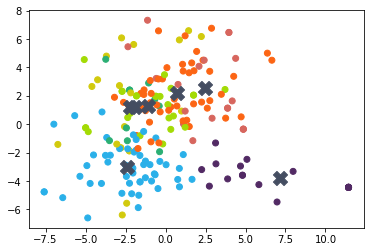

In [21]:
from sklearn.decomposition import PCA

pca =PCA(n_components=5).fit(bert_embedding)
coords = pca.transform(bert_embedding)
label_colors = ['#2AB0E9','#2BAF74','#D7665E','#D2CA0D','#522A64','#A3DB05','#FC6514','#C7549F','#58C754','#C75459']
colors = [label_colors[i] for i in labels]
plt.scatter(coords[:,0],coords[:,1],c=colors)
centriods =clf.cluster_centers_
centriod_coords =pca.transform(centriods)
plt.scatter(centriod_coords[:,0],centriod_coords[:,1],marker='X',s=200, linewidths=1,c='#444d61')
plt.show()

In [22]:
processed = df1['processed']

In [23]:
clusters = pd.DataFrame([processed , labels]).T
clusters.columns = ['cleaned_txt' ,'label' ]
clusters[:5]

,cleaned_txt,label
0,"[social, medium, user, demand, cnn, respond, d...",1
1,"[israeli, prime, minister, benjamin, netanyahu...",4
2,"[brooklyn, nets, enter, sunday, night, game, c...",4
3,"[nebraska, governor, pete, ricketts, find, cdc...",6
4,"[villagers, grow, flower, shanchong, village, ...",0


In [25]:
clusters['label'].value_counts()

0    51
6    50
5    25
3    21
4    19
2    19
1    11
Name: label, dtype: int64

In [ ]:
#clusters[clusters['label']== 2].values

In [26]:
final_txt = pd.concat([df1 , clusters] , axis = 1)
final_txt[:5]

,index,text,processed,cleaned_txt,label
0,0,Social media users are demanding CNN respond a...,"[social, medium, user, demand, cnn, respond, d...","[social, medium, user, demand, cnn, respond, d...",1
1,1,Israeli Prime Minister Benjamin Netanyahu dire...,"[israeli, prime, minister, benjamin, netanyahu...","[israeli, prime, minister, benjamin, netanyahu...",4
2,2,The Brooklyn Nets enter Sunday night’s game ag...,"[brooklyn, nets, enter, sunday, night, game, c...","[brooklyn, nets, enter, sunday, night, game, c...",4
3,5,Nebraska Governor Pete Ricketts said he found ...,"[nebraska, governor, pete, ricketts, find, cdc...","[nebraska, governor, pete, ricketts, find, cdc...",6
4,11,"Villagers grow flowers in Shanchong Village, Z...","[villagers, grow, flower, shanchong, village, ...","[villagers, grow, flower, shanchong, village, ...",0


In [27]:
final_txt[final_txt['label']== 7].values

array([], shape=(0, 5), dtype=object)

<h2><b> Saving the model weights </b></h2>

In [28]:
from sklearn.externals import joblib
  
# Save the model as a pickle in a file
joblib.dump(clf, 'weights.h5')
  

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['weights.h5']

<hr><h2><b>Inference Code </b></h2>

In [33]:
import numpy as np
import pandas as pd
import joblib
import spacy
import re
from spacy.lang.en import English
from sentence_transformers import SentenceTransformer

def inf_code(data):
  def process_text(data):
    nlp = spacy.load('en_core_web_sm') 
    #function that returns processed text
    master = []
  
    for text in data:
        #print(text)
        doc = nlp(text)
        slave = []

        for token in doc:
            if not token.is_stop and not token.is_punct:
                if not token.like_num:  
                    slave.append(token.lemma_.lower().replace('\n',''))
        master.append(' '.join(slave))
    return master

  def embedding(data):
    #function that returns embedding from processed text
    result = process_text(data)
    sentence_bert_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
    corpus_embs = sentence_bert_model.encode(result)
    return corpus_embs


  def predict_result(data):
    #function that predict the cluster from embedding of text
    model = joblib.load('weights.h5') 
    embd = embedding(data)
    output = model.predict(embd)
    return output
  
  final = predict_result(data)
  return final

data = ["In view of Cyclone Tauktae, no Covid-19 vaccine doses will be administered in the state of Gujarat on May 17 and 18. The state’s vaccination drive is on hold till May 19.\n\nDeemed a very severe cyclonic storm, Cyclone Tauktae over east central Arabian Sea"]

cluster = inf_code(data)
print("The resultant cluster is:-", cluster)

The resultant cluster is:- [3]
